In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import sklearn

from sklearn import metrics
from scipy import stats
from collections import Counter

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# import torch
# torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
# print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

import training_utils.dataset_utils as data_utils
import training_utils.partitioning_utils as pat_utils

import importlib
import training_utils.train_utils as train_utils
importlib.reload(train_utils)

<module 'training_utils.train_utils' from '/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/training_utils/train_utils.py'>

In [2]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
os.environ["WANDB_NOTEBOOK_NAME"] = "DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/09_InfoNCELoss_instead_of_BCELoss.ipynb"
import wandb
wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts/09_InfoNCELoss_instead_of_BCELoss.ipynb.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zhome/c9/0/203261/.netrc
wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

# batch_size = 20
learning_rate = 2e-5
EPOCHS = 15

## InfoNCE instead of BCE

In [6]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

## Embeddings paths
binders_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
targets_embeddings = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


#### Loading data frame

In [7]:
### Loading the dataset
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})

all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not

### Weights for binder/non-binders
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["class_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
# binder_nonbinder_weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["class_weight"]))

### Weights for target
N_bins = len(interaction_df["target_id_mod"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["target_id_mod"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["target_weight"] = interaction_df.target_id_mod.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])

### Combined weights
interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Remove FGFR2
interaction_df_withoutFGFR2 = interaction_df[interaction_df.target_id_mod != "FGFR2"]

### Combined weights (boost positives, reduce number of FGFR2 binder)
multipliers = []
for name in interaction_df["target_id_mod"]:
    if name == "FGFR2":
        multipliers.append(1)
    else:
        multipliers.append(10)
interaction_df["target_weight_FGFR2_reduced"] = interaction_df["target_weight"] * multipliers

### Combined weights
# interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Combined weights (boost positives)
multipliers = []
for binder in interaction_df["binder"]:
    if binder == False:
        multipliers.append(1)
    else:
        multipliers.append(5)
interaction_df["combined_weight_boost_pos"] = ((interaction_df["class_weight"]+interaction_df["target_weight_FGFR2_reduced"])/2) * multipliers

u = interaction_df[['binder', 'target_id_mod', 'combined_weight_boost_pos']].drop_duplicates(subset=['target_id_mod', 'binder'])
# print(u.sort_values('target_id_mod').to_string(index=False))
# or as a dict:
weight_map = u.set_index('target_id_mod')['combined_weight_boost_pos'].to_dict()

interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight,target_weight_FGFR2_reduced,combined_weight_boost_pos
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395,0.006313,0.003236
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553,0.009470,0.004814
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553,0.009470,0.004814
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553,0.009470,0.004814
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553,0.009470,0.004814


### 5-fold CV training + weighting of samples

In [8]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [9]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


In [10]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    train_targets = cv_splits[idx][1]
    print(f"Fold {idx+1} : validation targets : {val_targets}")

Fold 1 : validation targets : ['FGFR2', 'Mdm2', 'LTK']
Fold 2 : validation targets : ['SARS_CoV2_RBD', 'sntx', 'sntx_2', 'IL7Ra']
Fold 3 : validation targets : ['InsulinR', 'TrkA', 'IL10Ra']
Fold 4 : validation targets : ['EGFR', 'EGFR_2', 'EGFR_3', 'VirB8']
Fold 5 : validation targets : ['IL2Ra', 'Pdl1']


In [11]:
interaction_df.loc[interaction_df.target_id_mod.isin(cv_splits[1][1])].binder.value_counts()

binder
False    2876
True      337
Name: count, dtype: int64

### Creating separate targets/ binder dataframes

In [12]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder", "class_weight", "target_weight", "combined_weight"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

### Class for loading binders/targets

In [13]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████| 3532/3532 [00:05<00:00, 629.49it/s]


In [14]:
# checking if _get_by_name function gives the same output as index used
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [15]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl, tname))

    return listof_bindertargetlabel

ALL_bemb_temb_lbl_tname = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)

In [16]:
binders = torch.stack([torch.as_tensor(b) for b,_,_,_ in ALL_bemb_temb_lbl_tname])
targets = torch.stack([torch.as_tensor(t) for _,t,_,_ in ALL_bemb_temb_lbl_tname])
labels  = torch.tensor([float(y) for _,_,y,_ in ALL_bemb_temb_lbl_tname], dtype=torch.float32)
t_names = [tn for *_, tn in ALL_bemb_temb_lbl_tname]  # plain list of strings

class PairListDataset(Dataset):
    def __init__(self, B, T, Y, names):
        self.B, self.T, self.Y, self.names = B, T, Y, names
    def __len__(self): return len(self.Y)
    def __getitem__(self, i):
        return self.B[i], self.T[i], self.Y[i], self.names[i]

ALL_btl = PairListDataset(binders, targets, labels, t_names)

### Training class

In [17]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

all_hist = []

class TrainWrapper_MetaAnal():

    def __init__(self, 
                 model, 
                 training_loader, 
                 validation_loader, 
                 test_dataset, 
                 optimizer, 
                 scheduler, 
                 EPOCHS, 
                 runID, 
                 pos_weight=None, 
                 device = device, 
                 test_indexes_for_auROC=None,
                 auROC_batch_size=20, 
                 model_save_steps=False, 
                 model_save_path=False, 
                 v=False, 
                 wandb_tracker=False, 
                 split_id=None
                ):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.pos_weight = pos_weight
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.pos_weight, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
            
        if self.scheduler is not None:
            self.scheduler.step()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):

        if batch_size==20:
            batch_size = self.auROC_batch_size
            
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(
            dataloader=self.validation_loader, 
            indexes_for_auc=self.test_indexes_for_auROC, 
            auROC_dataset=self.test_dataset
        )

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(
                dataloader=self.validation_loader, 
                indexes_for_auc=self.test_indexes_for_auROC, 
                auROC_dataset=self.test_dataset
            )
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

In [18]:
targets = ["s", "v", "s", "t", "s", "t", "t", "t", "t", "t"]
N = len(targets)
interactions, idx = torch.zeros(N, N), torch.arange(N)
labels = torch.tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=interactions.dtype, device=interactions.device)
interactions[idx, idx] = labels

t_count = Counter(targets)
for i, t in enumerate(targets):
    if labels[i] == 1 and t_count[t] > 1:
        col_mask = torch.tensor([tt == t for tt in targets], dtype=torch.bool)
        interactions[i, col_mask] = 1
interactions

tensor([[1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 1.]])

In [19]:
torch.diagonal(interactions)

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [20]:
neg_mask = ~interactions.bool()
neg_mask

tensor([[False,  True, False,  True, False,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True, False, False, False, False, False]])

In [21]:
for i in range(N):
    pos_idx = interactions[i].nonzero(as_tuple=False).view(-1)
    print(pos_idx)
    if len(pos_idx) == 0:
        continue

tensor([0, 2, 4])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([3, 5, 6, 7, 8, 9])
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([], dtype=torch.int64)
tensor([3, 5, 6, 7, 8, 9])


In [22]:
# import torch
# import torch.nn.functional as F
# def multi_pos_info_nce(pep_emb, prot_emb, interactions, temperature=0.1):
#    """
#    Multi-positive InfoNCE with masking duplicates.
#    """
#    # Normalize embeddings
#    pep_norm = F.normalize(pep_emb, dim=-1)
#    prot_norm = F.normalize(prot_emb, dim=-1)
#    # Similarity matrix
#    sim = pep_norm @ prot_norm.T / temperature  # [B_pep, B_prot]
#    # Mask negatives: only non-interacting pairs
#    neg_mask = ~interactions  # True for negatives
#    loss = 0.0
#    count = 0
#    B_pep, B_prot = interactions.shape
#    for i in range(B_pep):
#        # Indices of positives for this peptide
#        pos_idx = interactions[i].nonzero(as_tuple=False).view(-1)
#        if len(pos_idx) == 0:
#            continue
#        # Mask duplicates: take only one occurrence per target
#        pos_idx = pos_idx.unique()
#        # Numerator: sum over positives
#        numerator = torch.exp(sim[i][pos_idx]).sum()
#        # Denominator: sum over negatives + positives
#        denom = torch.exp(sim[i][neg_mask[i]]).sum() + numerator
#        loss += -torch.log(numerator / denom)
#        count += 1
#    loss = loss / max(count, 1)
#    return loss
# # Symmetric loss: peptide->protein and protein->peptide
# loss_pep2prot = multi_pos_info_nce(pep_emb, prot_emb, interactions)
# loss_prot2pep = multi_pos_info_nce(prot_emb, pep_emb, interactions.T)
# loss = 0.5 * (loss_pep2prot + loss_prot2pep)

In [23]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def interactions_matrix(embedding_pep, binder_labels, targets, device=device):
    N = len(embedding_pep)
    device = binder_labels.device
    interactions = torch.zeros(N, N, device=device)
    idx = torch.arange(N, device=device)        # diagonal = labels
    interactions[idx, idx] = binder_labels

    t_count = Counter(targets)                   # targets can be a list[str]
    # loop on CPU-friendly objects; use .item() for tensor labels
    for i, t in enumerate(targets):
        if binder_labels[i].item() == 1 and t_count[t] > 1:
            col_mask = torch.tensor([tt == t for tt in targets], dtype=torch.bool, device=device)
            interactions[i, col_mask] = 1
    return interactions

def multi_pos_info_nce(pep_emb, prot_emb, interactions, batch_size, tau, device=device):

    # cosine/dot similarities as logits (diagonal with 1s should score higher)
    logits = (pep_emb @ prot_emb.T) / tau
    device = logits.device

    # since we have more identical targets per batch, they are masked
    neg_mask = ~interactions.bool() 
    inNCELoss_binder, inNCELoss_target, count = 0.0, 0.0, 0
    
    # binder --> target mapping
    for i in range(batch_size):
        pos_idx = interactions[i].nonzero(as_tuple=False).view(-1)
        if pos_idx.numel() == 0:
            continue
        inNCELoss_binder += -torch.log(
            (torch.exp(logits[i, i])) /
            (torch.exp(logits[i, neg_mask[i]]).sum() + torch.exp(logits[i, i]))
        )
        count += 1

    # target -> binder
    for j in range(batch_size):
        pos_idx = interactions[j].nonzero(as_tuple=False).view(-1)
        if pos_idx.numel() == 0:
            continue
        inNCELoss_target += -torch.log(
            (torch.exp(logits[j, j])) /
            (torch.exp(logits[neg_mask[:][j], j]).sum() + torch.exp(logits[j, j]))
        )
        count += 1

    if count == 0:
        loss = torch.tensor(0.0, device=device)
    else:
        loss = 0.5 * (inNCELoss_binder + inNCELoss_target) / count
    
    return loss, torch.diagonal(logits)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(0.07))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )

        # self.pep_embedder = nn.Sequential(
        #     nn.Linear(self.embed_dimension, 640),
        #     nn.ReLU(),
        #     nn.Linear(640, 320),
        # )
        
    def forward(self, pep_input, prot_input, interactions, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            # pep_emb = pep_emb + pep_cross  
            # prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            pep_emb  = self.norm(pep_emb  + pep_trans  + pep_cross)
            prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # L2-normalize
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))

        # scaler
        tau = torch.exp(self.logit_scale).clamp(max=100.0)
        # Loss
        InfoNCELoss, logits = multi_pos_info_nce(
            pep_seq_coding, prot_seq_coding, interactions, 
            batch_size = len(pep_input), tau=tau)
                
        return logits, InfoNCELoss

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels, targets = batch
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)
        binder_labels = binder_labels.to(device).float()
    
        # If no positives in batch, return a graph-attached zero to keep backward happy
        if (binder_labels == 1).sum() == 0:
            return torch.zeros((), device=device, requires_grad=True)

        interactions = interactions_matrix(embedding_pep, binder_labels, targets, device=device)
        logits, loss = self.forward(embedding_pep, embedding_prot, interactions)
        return loss  # tensor with grad_fn
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels, targets = batch
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)
        binder_labels = binder_labels.to(device).float()
    
        interactions = interactions_matrix(embedding_pep, binder_labels, targets)
        
        with torch.no_grad():
            logits, loss = self.forward(embedding_pep, embedding_prot, interactions)
        return float(loss), logits, binder_labels

In [24]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
# model.load_state_dict(checkpoint['model_state_dict'])
# torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
# device = torch.device("cuda:0")
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

Training model 9c76f5ac-1977-49ab-9970-d8f403b87ebb
Before training - Val Loss 0.3156 | Val AUROC 0.5517 | Val AUPR 0.2335
EPOCH 1 - Train Loss 1.3652 | Val Loss 0.3127 | Val AUROC 0.6164 | Val AUPR 0.2169
EPOCH 2 - Train Loss 1.2394 | Val Loss 0.3095 | Val AUROC 0.5887 | Val AUPR 0.2081
EPOCH 3 - Train Loss 1.3221 | Val Loss 0.3079 | Val AUROC 0.4954 | Val AUPR 0.1257
EPOCH 4 - Train Loss 1.2935 | Val Loss 0.3080 | Val AUROC 0.5593 | Val AUPR 0.1719
EPOCH 5 - Train Loss 1.2713 | Val Loss 0.3072 | Val AUROC 0.4670 | Val AUPR 0.1173
EPOCH 6 - Train Loss 1.2983 | Val Loss 0.3074 | Val AUROC 0.5411 | Val AUPR 0.1879
EPOCH 7 - Train Loss 1.3194 | Val Loss 0.3076 | Val AUROC 0.5776 | Val AUPR 0.2207
EPOCH 8 - Train Loss 1.3377 | Val Loss 0.3070 | Val AUROC 0.4488 | Val AUPR 0.1220
EPOCH 9 - Train Loss 1.2925 | Val Loss 0.3085 | Val AUROC 0.6601 | Val AUPR 0.2322
EPOCH 10 - Train Loss 1.2466 | Val Loss 0.3079 | Val AUROC 0.6500 | Val AUPR 0.2427
EPOCH 11 - Train Loss 1.2939 | Val Loss 0.3075

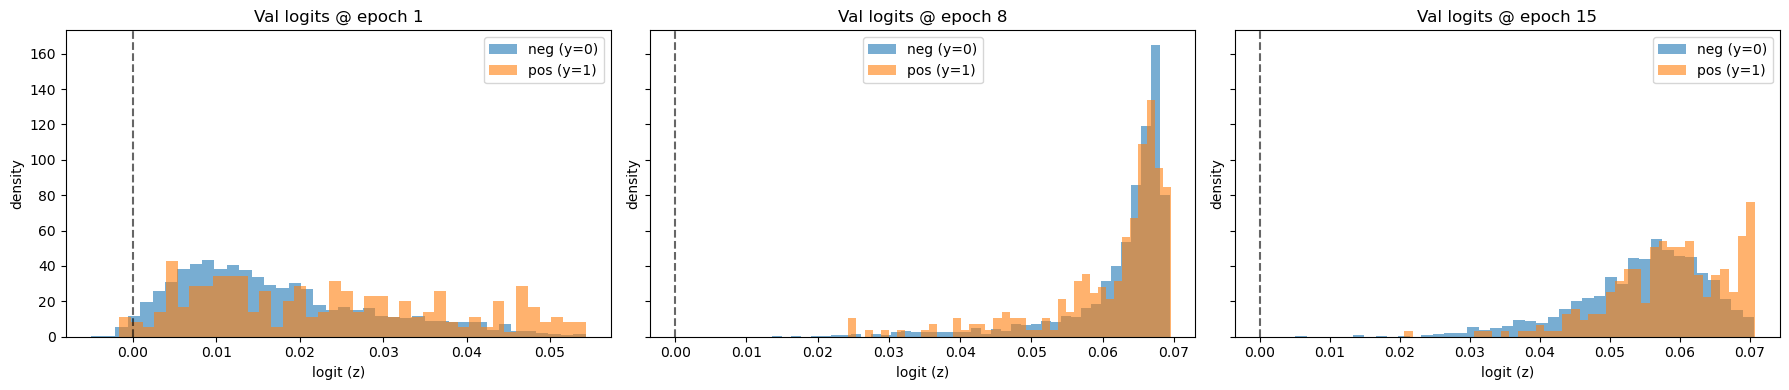

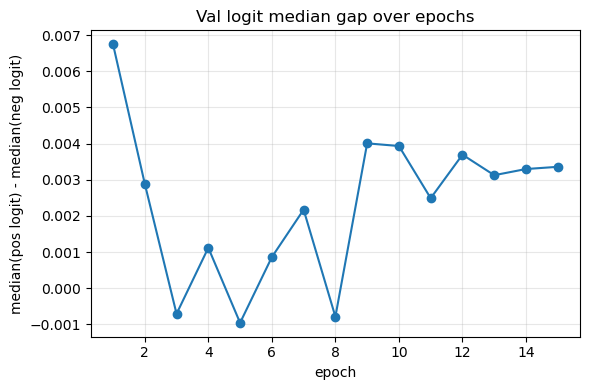

Train Loss,█▂▆▄▃▅▆▇▄▂▄▁▅▅▁
Val AUPR,▇▇▆▁▄▁▅▇▁▇██████
Val AUROC,▄▇▆▃▅▂▄▅▁██▇█▇▇▇
Val Loss,█▆▃▂▂▁▁▂▁▂▂▁▂▂▂▂
val_logit_gap,█▄▁▃▁▃▄▁▆▅▄▅▅▅▅
val_neg_median_logit,▁▄▇▇█▇▆█▇▇▇▇▇▇▇
val_pos_median_logit,▁▄▆▇█▇▆██▇▇█▇▇▇
Train Loss,1.22366
Val AUPR,0.23878
Val AUROC,0.63481
Val Loss,0.30773


Training model 9c76f5ac-1977-49ab-9970-d8f403b87ebb
Before training - Val Loss 1.1501 | Val AUROC 0.5173 | Val AUPR 0.1609
EPOCH 1 - Train Loss 1.0531 | Val Loss 1.1472 | Val AUROC 0.6808 | Val AUPR 0.3016
EPOCH 2 - Train Loss 1.0374 | Val Loss 1.1476 | Val AUROC 0.6819 | Val AUPR 0.3036
EPOCH 3 - Train Loss 1.0003 | Val Loss 1.1477 | Val AUROC 0.6806 | Val AUPR 0.2993
EPOCH 4 - Train Loss 0.9863 | Val Loss 1.1477 | Val AUROC 0.6753 | Val AUPR 0.2902
EPOCH 5 - Train Loss 1.0265 | Val Loss 1.1477 | Val AUROC 0.6692 | Val AUPR 0.2801
EPOCH 6 - Train Loss 1.0068 | Val Loss 1.1477 | Val AUROC 0.6637 | Val AUPR 0.2729
EPOCH 7 - Train Loss 1.0153 | Val Loss 1.1478 | Val AUROC 0.6608 | Val AUPR 0.2692
EPOCH 8 - Train Loss 0.9994 | Val Loss 1.1478 | Val AUROC 0.6601 | Val AUPR 0.2684
EPOCH 9 - Train Loss 1.0005 | Val Loss 1.1478 | Val AUROC 0.6594 | Val AUPR 0.2665
EPOCH 10 - Train Loss 0.9827 | Val Loss 1.1478 | Val AUROC 0.6577 | Val AUPR 0.2639
EPOCH 11 - Train Loss 1.0004 | Val Loss 1.1478

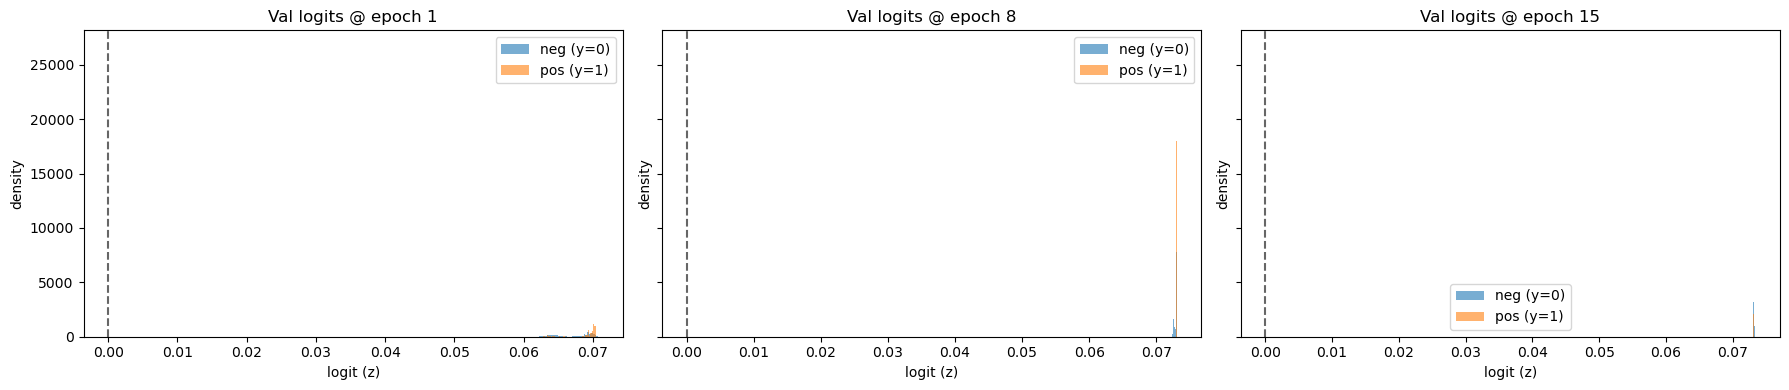

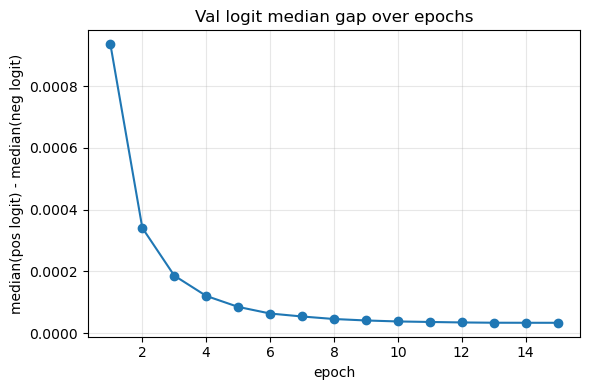

Train Loss,▇▅▂▁▄▃▄▂▂▁▂▂▃▃█
Val AUPR,▁███▇▇▆▆▆▆▆▆▆▆▆▆
Val AUROC,▁████▇▇▇▇▇▇▇▇▇▇▇
Val Loss,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_logit_gap,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_neg_median_logit,▁▄▆▆▇▇▇▇███████
val_pos_median_logit,▁▄▅▆▆▇▇▇███████
Train Loss,1.07088
Val AUPR,0.26177
Val AUROC,0.65594
Val Loss,1.14777


Training model 9c76f5ac-1977-49ab-9970-d8f403b87ebb
Before training - Val Loss 0.9543 | Val AUROC 0.4854 | Val AUPR 0.1264
EPOCH 1 - Train Loss 1.0411 | Val Loss 0.9519 | Val AUROC 0.5887 | Val AUPR 0.1648
EPOCH 2 - Train Loss 1.0216 | Val Loss 0.9524 | Val AUROC 0.5879 | Val AUPR 0.1658
EPOCH 3 - Train Loss 1.0187 | Val Loss 0.9524 | Val AUROC 0.5862 | Val AUPR 0.1652
EPOCH 4 - Train Loss 1.0200 | Val Loss 0.9525 | Val AUROC 0.5771 | Val AUPR 0.1624
EPOCH 5 - Train Loss 1.0150 | Val Loss 0.9525 | Val AUROC 0.5759 | Val AUPR 0.1589
EPOCH 6 - Train Loss 1.0365 | Val Loss 0.9525 | Val AUROC 0.5753 | Val AUPR 0.1587
EPOCH 7 - Train Loss 1.0388 | Val Loss 0.9525 | Val AUROC 0.5682 | Val AUPR 0.1565
EPOCH 8 - Train Loss 1.0804 | Val Loss 0.9525 | Val AUROC 0.5674 | Val AUPR 0.1565
EPOCH 9 - Train Loss 1.0638 | Val Loss 0.9525 | Val AUROC 0.5644 | Val AUPR 0.1557
EPOCH 10 - Train Loss 1.0419 | Val Loss 0.9525 | Val AUROC 0.5647 | Val AUPR 0.1554
EPOCH 11 - Train Loss 1.0225 | Val Loss 0.9525

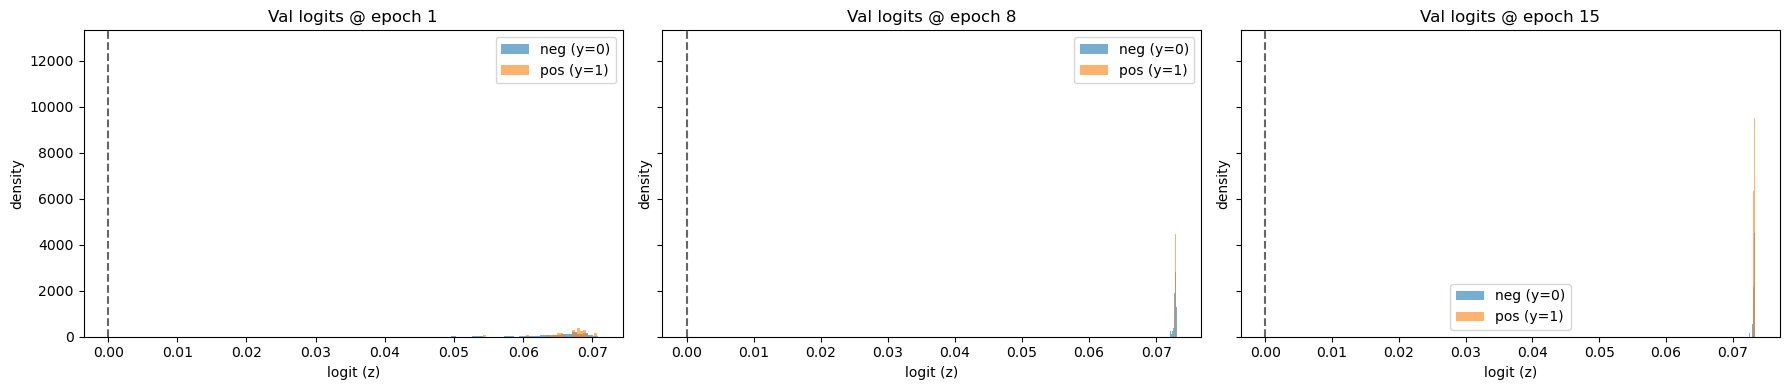

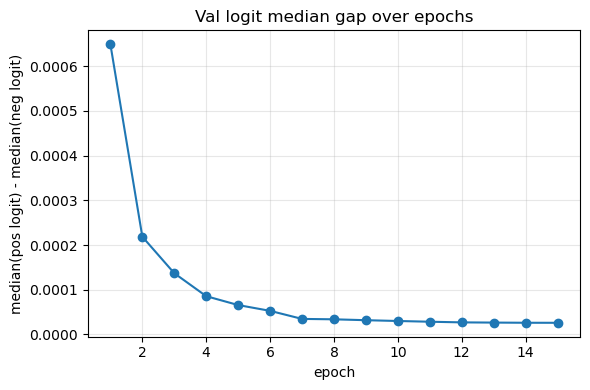

Train Loss,▄▂▁▂▁▃▄█▆▄▂▂▄▅▆
Val AUPR,▁███▇▇▇▆▆▆▆▆▆▆▆▆
Val AUROC,▁███▇▇▇▇▇▆▆▆▆▆▆▆
Val Loss,█▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃
val_logit_gap,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_neg_median_logit,▁▅▆▆▇▇▇████████
val_pos_median_logit,▁▅▆▆▇▇▇████████
Train Loss,1.05834
Val AUPR,0.15478
Val AUROC,0.56206
Val Loss,0.95254


Training model 9c76f5ac-1977-49ab-9970-d8f403b87ebb
Before training - Val Loss 0.9820 | Val AUROC 0.5814 | Val AUPR 0.0893
EPOCH 1 - Train Loss 1.0062 | Val Loss 0.9795 | Val AUROC 0.6182 | Val AUPR 0.2056
EPOCH 2 - Train Loss 1.0218 | Val Loss 0.9796 | Val AUROC 0.6093 | Val AUPR 0.1313
EPOCH 3 - Train Loss 1.0322 | Val Loss 0.9796 | Val AUROC 0.6000 | Val AUPR 0.1169
EPOCH 4 - Train Loss 1.0071 | Val Loss 0.9796 | Val AUROC 0.5950 | Val AUPR 0.1107
EPOCH 5 - Train Loss 1.0087 | Val Loss 0.9796 | Val AUROC 0.5914 | Val AUPR 0.1093
EPOCH 6 - Train Loss 1.0150 | Val Loss 0.9796 | Val AUROC 0.5872 | Val AUPR 0.1065
EPOCH 7 - Train Loss 1.0152 | Val Loss 0.9796 | Val AUROC 0.5845 | Val AUPR 0.1048
EPOCH 8 - Train Loss 1.0403 | Val Loss 0.9796 | Val AUROC 0.5825 | Val AUPR 0.1033
EPOCH 9 - Train Loss 1.0075 | Val Loss 0.9796 | Val AUROC 0.5815 | Val AUPR 0.1036
EPOCH 10 - Train Loss 1.0699 | Val Loss 0.9796 | Val AUROC 0.5809 | Val AUPR 0.1040
EPOCH 11 - Train Loss 1.0456 | Val Loss 0.9796

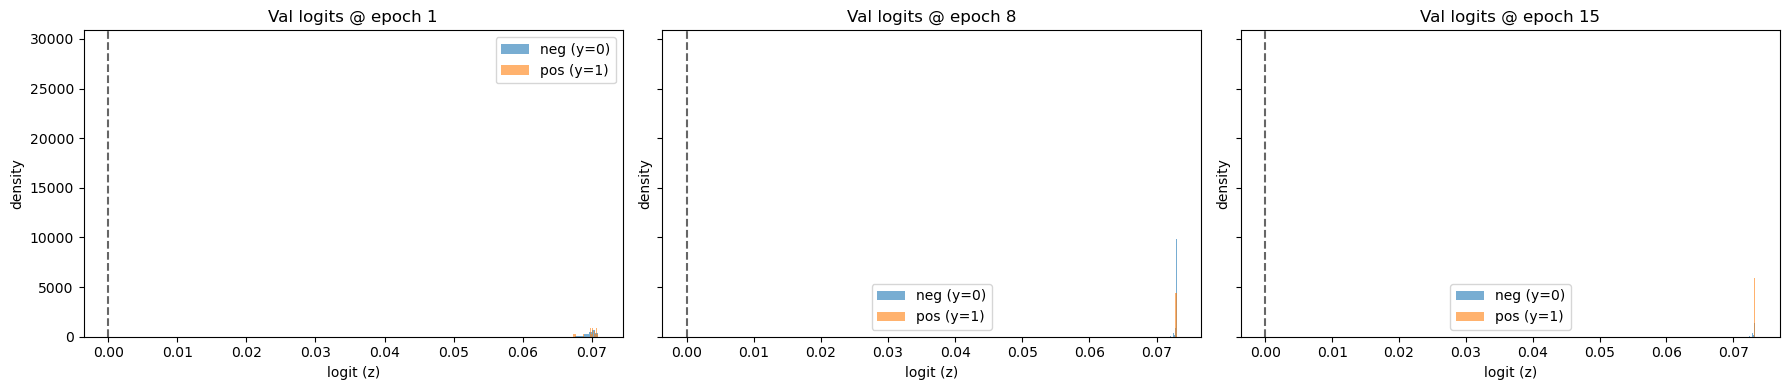

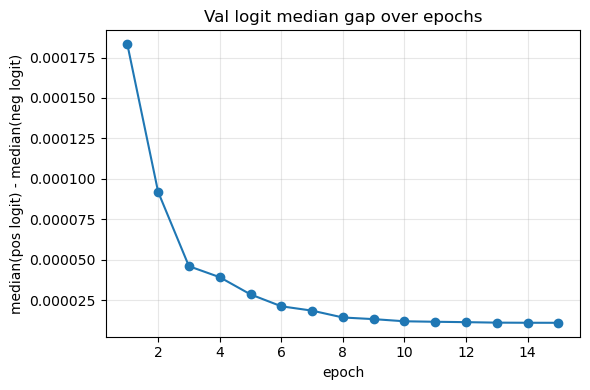

Train Loss,▁▃▄▂▂▂▂▅▂█▆▂▄▁▂
Val AUPR,▁█▄▃▂▂▂▂▂▂▂▂▂▂▂▂
Val AUROC,▁█▆▅▄▃▂▂▁▁▁▁▁▁▁▁
Val Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_logit_gap,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
val_neg_median_logit,▁▄▅▆▆▇▇▇███████
val_pos_median_logit,▁▄▅▆▆▇▇▇███████
Train Loss,1.00805
Val AUPR,0.10379
Val AUROC,0.58193
Val Loss,0.97965


Training model 9c76f5ac-1977-49ab-9970-d8f403b87ebb
Before training - Val Loss 0.1386 | Val AUROC 0.5214 | Val AUPR 0.1412
EPOCH 1 - Train Loss 1.1123 | Val Loss 0.1385 | Val AUROC 0.5462 | Val AUPR 0.1713
EPOCH 2 - Train Loss 1.0247 | Val Loss 0.1385 | Val AUROC 0.5513 | Val AUPR 0.1676
EPOCH 3 - Train Loss 1.0467 | Val Loss 0.1385 | Val AUROC 0.5575 | Val AUPR 0.1646
EPOCH 4 - Train Loss 1.0762 | Val Loss 0.1385 | Val AUROC 0.5575 | Val AUPR 0.1608
EPOCH 5 - Train Loss 1.0851 | Val Loss 0.1385 | Val AUROC 0.5692 | Val AUPR 0.1670
EPOCH 6 - Train Loss 1.0558 | Val Loss 0.1385 | Val AUROC 0.5703 | Val AUPR 0.1624
EPOCH 7 - Train Loss 1.0291 | Val Loss 0.1385 | Val AUROC 0.5761 | Val AUPR 0.1658
EPOCH 8 - Train Loss 1.0705 | Val Loss 0.1385 | Val AUROC 0.5798 | Val AUPR 0.1670
EPOCH 9 - Train Loss 1.0571 | Val Loss 0.1385 | Val AUROC 0.5837 | Val AUPR 0.1701
EPOCH 10 - Train Loss 1.1223 | Val Loss 0.1385 | Val AUROC 0.5862 | Val AUPR 0.1756
EPOCH 11 - Train Loss 1.0191 | Val Loss 0.1385

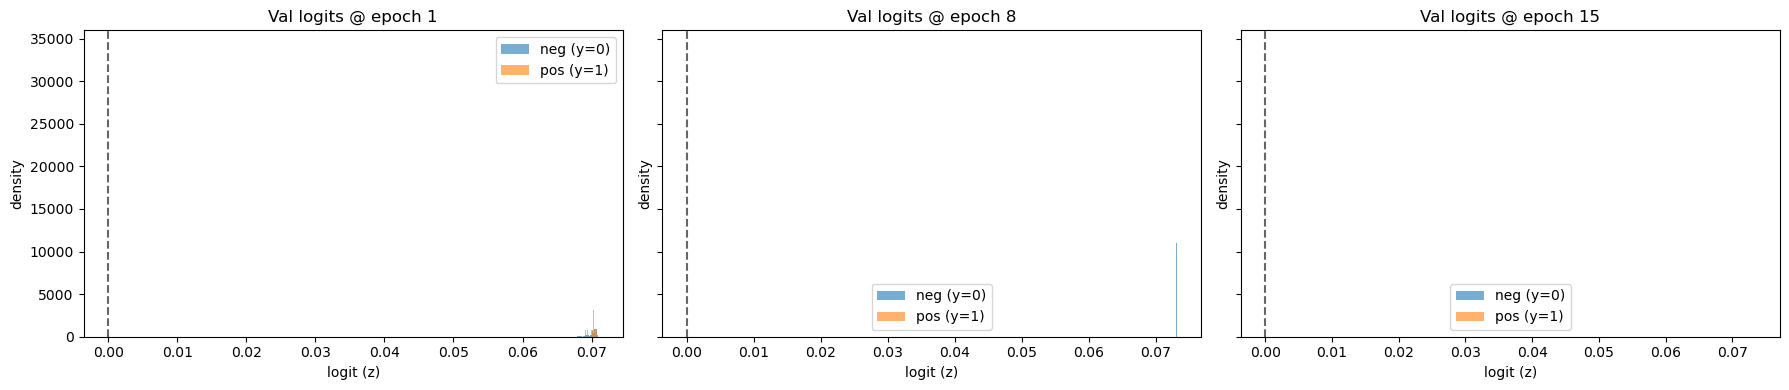

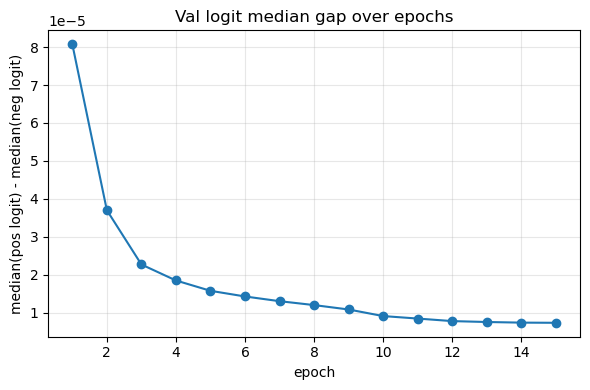

Train Loss,▇▁▃▅▅▃▂▄▄█▁▇▃▆▄
Val AUPR,▁▇▆▆▅▆▅▆▆▇██████
Val AUROC,▁▄▄▅▅▆▆▇▇▇██████
Val Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_logit_gap,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁
val_neg_median_logit,▁▄▅▆▆▇▇▇▇██████
val_pos_median_logit,▁▄▅▆▆▇▇▇▇██████
Train Loss,1.06281
Val AUPR,0.17539
Val AUROC,0.58936
Val Loss,0.13846


In [25]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 15
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_loader = DataLoader(val_binders,  batch_size=batch_size, shuffle=False, drop_last = False)

    # training
    train_targets = cv_splits[i][1]
    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]

    # train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    # train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    # train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    # train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined_boost_positives, num_samples=train_binders.__len__(), replacement=True, generator = g)
    # train_loader   = DataLoader(train_binders, batch_size=batch_size, sampler=train_sampler)
    train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)
    
    pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
    neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
    pos_weight = torch.tensor(neg / max(pos, 1))

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="CLIP_PPint_metaanalysis_InfoNCE",
            name=f"CV_split{i+1}_InfoNCE",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,
        optimizer=optimizer,
        scheduler = scheduler,
        EPOCHS=EPOCHS,
        pos_weight = None,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        auROC_batch_size = batch_size,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass